In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import time

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### WINE DATASET

In [62]:
data = pd.read_csv('WineQT.csv')
data = data.values
data = data[:, :-1]
labels = data[:, -1]
x = data[:, :-1]
scaler = StandardScaler()
x = scaler.fit_transform(x)

normalizer = Normalizer()
x = normalizer.fit_transform(x)

x_train_wine, x_test_wine, y_train_wine, y_test_wine = train_test_split(x, labels, test_size=0.2, random_state=42)
x_train_wine, x_val_wine, y_train_wine, y_val_wine = train_test_split(x_train_wine, y_train_wine, test_size=0.1, random_state=42)

print(x_train_wine.shape)
print(x_val_wine.shape)
print(x_test_wine.shape)

y_train_wine = y_train_wine.astype('int')-3
y_test_wine = y_test_wine.astype('int')-3
y_val_wine = y_val_wine.astype('int')-3

(822, 11)
(92, 11)
(229, 11)


#### MODELS FOR CLASSIFICATION

##### MULTINOMIAL LOGISTIC REGRESSION MODEL

In [63]:
class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, verbose=True):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.loss = []
        self.weights = None
        self.bias = None
        self.verbose = verbose
        
    def fit(self, x, y,x_val,y_val):
        self.loss = []
        self.weights = np.zeros((x.shape[1], len(np.unique(labels))))
        self.bias = np.zeros(len(np.unique(labels)))
        y = self.one_hot_encode(y)
        for i in range(self.max_iter):

            loss = self.cross_entropy_loss(x, y)
            self.loss.append(loss)

            dw, db = self.gradient(x, y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            accuracy = self.score(x_val, y_val)
            val_loss = self.cross_entropy_loss(x_val, self.one_hot_encode(y_val))
            if self.verbose:
                print("Iteration: {0}, Loss: {1:.4f}, Val Accuracy: {2:.4f}, Val Loss: {3:.4f}".format(i+1, loss, accuracy, val_loss))

            if loss < self.tol:
                break
        return self
    
    def score(self, x, y):
        y_pred = self.predict(x)
        accuracy = np.sum(y_pred == y) / len(y)
        return accuracy
    
    def predict(self, x):
        probs = self.softmax(x)
        return np.argmax(probs, axis=1)
    
    def predict_proba(self, x):
        probs = self.softmax(x)
        return probs
    
    def softmax(self, x):
        scores = np.dot(x, self.weights) + self.bias
        probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
        return probs
    
    def cross_entropy_loss(self, x, y):
        probs = self.softmax(x)
        loss = -np.sum(y * np.log(probs)) / len(x)
        return loss
    
    def gradient(self, x, y):
        probs = self.softmax(x)
        dw = np.dot(x.T, (probs - y)) / len(x)
        db = np.sum(probs - y) / len(x)
        return dw, db
    
    def one_hot_encode(self, y):
        y = np.eye(len(np.unique(labels)))[y]
        return y
    
    def plot_loss(self):
        plt.plot(self.loss)
        plt.title("Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()

# Best model : model = MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000)

##### MLP CLASSIFIER

In [64]:
class MLPClassifier:
    def __init__(self, learning_rate=0.01, epochs=1000, activation='sigmoid', neurons = 10, optimizer='sgd', mini_batch_size=None, hidden_layers=1, verbose = True):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation = activation
        self.neurons = neurons
        self.loss = []
        self.val_loss = []
        self.weights = []
        self.bias = []
        self.optimizer = optimizer
        self.mini_batch_size = mini_batch_size
        self.hidden_layers = hidden_layers
        self.verbose = verbose

    # activation functions

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def gradient_sigmoid(self, x):
        return x * (1 - x)
    
    def gradient_tanh(self, x):
        return 1 - (x ** 2)
    
    def gradient_relu(self, x):
        return 1 * (x > 0)
    
    # optimizer functions

    def sgd(self, x, y):
        for i in range(len(x)):
            x_reshaped = x[i].reshape(1, -1)
            z = self.forward(x_reshaped)
            grad_w, grad_b = self.backward(x_reshaped, y[i], z)
            self.update_weights(x_reshaped, grad_w)
            self.update_bias(x_reshaped,grad_b)
    
    def bgd(self, x, y):
        z = self.forward(x)
        grad_w, grad_b = self.backward(x, y, z)
        self.update_weights(x, grad_w)
        self.update_bias(x,grad_b)

    def mbgd(self, x, y):
        for i in range(0, len(x), self.mini_batch_size):
            z = self.forward(x[i:i+self.mini_batch_size])
            grad_w, grad_b = self.backward(x[i:i+self.mini_batch_size], y[i:i+self.mini_batch_size], z)
            self.update_weights(x[i:i+self.mini_batch_size], grad_w)
            self.update_bias(x[i:i+self.mini_batch_size], grad_b)

    # forward and backward pass
    
    def forward(self, x):
        z = []
        for i in range(len(self.weights)):
            if i == 0:
                z.append(np.dot(x, self.weights[i]) + self.bias[i])
            else:
                z.append(np.dot(z[i-1], self.weights[i]) + self.bias[i])
            if i == len(self.weights) - 1:
                break
            if self.activation == 'sigmoid':
                z[i] = self.sigmoid(z[i])
            elif self.activation == 'tanh':
                z[i] = self.tanh(z[i])
            elif self.activation == 'relu':
                z[i] = self.relu(z[i])
        return z
    
    def backward(self, x, y, z):
        grad_w = []
        grad_b = []
        for i in reversed(range(len(self.weights))):
            if i == len(self.weights) - 1:
                error = z[i] - y
                grad = error
                grad_w.append(np.dot(z[i-1].T, error))
                grad_b.append(np.sum(error, axis=0, keepdims=True))
            elif i == 0:
                error = np.dot(grad, self.weights[i+1].T)
                if self.activation == 'sigmoid':
                    grad = error * self.gradient_sigmoid(z[i])
                elif self.activation == 'tanh':
                    grad = error * self.gradient_tanh(z[i])
                elif self.activation == 'relu':
                    grad = error * self.gradient_relu(z[i])
                grad_w.append(np.dot(x.T, grad))
                grad_b.append(np.sum(grad, axis=0, keepdims=True))
            else:
                error = np.dot(grad, self.weights[i+1].T)
                if self.activation == 'sigmoid':
                    grad = error * self.gradient_sigmoid(z[i])
                elif self.activation == 'tanh':
                    grad = error * self.gradient_tanh(z[i])
                elif self.activation == 'relu':
                    grad = error * self.gradient_relu(z[i])
                grad_w.append(np.dot(z[i-1].T, grad))
                grad_b.append(np.sum(grad, axis=0, keepdims=True))
        grad_w.reverse()
        grad_b.reverse()
        return grad_w, grad_b
    
    # update weights and bias

    def update_weights(self, x, grad_w):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grad_w[i]/len(x)
    
    def update_bias(self, x, grad_b):
        for i in range(len(self.bias)):
            self.bias[i] -= self.learning_rate * grad_b[i]/len(x)

    # fit and predict

    def fit(self, x, y, x_val, y_val):
        n_features = x.shape[1]
        n_classes = len(np.unique(labels))
        y = self.one_hot_encode(y)
        y_val = self.one_hot_encode(y_val)
        self.loss = []
        self.val_loss = []
        self.weights = []
        self.bias = []
        # multiple hidden layers
        for i in range(self.hidden_layers):
            if i == 0:
                self.weights.append(np.random.randn(n_features, self.neurons))
                self.bias.append(np.zeros((1, self.neurons)))
            else:
                self.weights.append(np.random.randn(self.neurons, self.neurons))
                self.bias.append(np.zeros((1, self.neurons)))
        self.weights.append(np.random.randn(self.neurons, n_classes))
        self.bias.append(np.zeros((1, n_classes)))
        for i in range(self.epochs):
            if self.optimizer == 'sgd':
                self.sgd(x, y)
            elif self.optimizer == 'bgd':
                self.bgd(x, y)
            elif self.optimizer == 'mbgd':
                self.mbgd(x, y)
            else:
                raise ValueError("Optimizer must be 'sgd', 'bgd', or 'mbgd'")
            loss = self.cross_entropy_loss(x, y)
            val_loss = self.cross_entropy_loss(x_val, y_val)
            self.loss.append(loss)
            self.val_loss.append(val_loss)
            val_accuracy = self.score1(x_val, y_val)
            accuracy = self.score1(x, y)
            if self.verbose:
                print("Iteration: {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Val Loss: {3:.4f}, Val Accuracy: {4:.4f}".format(i+1, loss, accuracy, val_loss, val_accuracy))
        return self

    def predict(self, x):
        probs = self.softmax(x)
        return np.argmax(probs, axis=1)
    
    def predict_proba(self, x):
        probs = self.softmax(x)
        return probs

    def one_hot_encode(self, y):
        y = np.eye(len(np.unique(labels)))[y]
        return y

    def softmax(self, x):
        z = self.forward(x)
        probs = np.exp(z[-1]) / np.sum(np.exp(z[-1]), axis=1, keepdims=True)
        return probs
    
    def cross_entropy_loss(self, x, y):
        probs = self.softmax(x)
        loss = -np.sum(y * np.log(probs)) / len(x)
        return loss
    
    def score1(self, x, y):
        y_pred = self.predict(x)
        accuracy = np.sum(y_pred == np.argmax(y, axis=1)) / len(x)
        return accuracy
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y = self.one_hot_encode(y)
        accuracy = np.sum(y_pred == np.argmax(y, axis=1)) / len(x)
        return accuracy
    
    def plot_loss(self):
        plt.plot(self.loss, label='loss')
        plt.plot(self.val_loss, label='val_loss')
        plt.title("Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Best model : final_model = MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3)


##### DECISION TREE CLASSIFIER

In [65]:
class DT_Classifier:
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.model = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)
    
    def fit(self, x, y, x_val, y_val):
        self.model.fit(x, y)
        accuracy = self.score(x_val, y_val)
        return self, accuracy
    
    def predict(self, x):
        return self.model.predict(x)
    
    def predict_proba(self, x):
        return self.model.predict_proba(x)
    
    def score(self, x, y):
        return self.model.score(x, y)
    
    def plot(self):
        plt.figure(figsize=(20, 20))
        tree.plot_tree(self.model, filled=True, rounded=True, class_names=['3', '4', '5', '6', '7', '8', '9'])
        plt.show()

#### BAGGING CLASSIFIER

In [66]:
class Bagging_classifier:
    def __init__(self, base_estimator, n_estimators, fraction, bootstrap, voting, verbose=True):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.fraction = fraction
        self.n_samples = None
        self.bootstrap = bootstrap
        self.voting = voting
        self.models = []
        self.accuracies = []
        self.accuracy = None
        self.f1 = None
        self.precision = None
        self.recall = None
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        self.n_samples = int(self.fraction * len(x))
        for i in range(self.n_estimators):
            if self.bootstrap:
                x_sample, y_sample = self.bootstrap_sampling(x, y)
            else:
                x_sample, y_sample = self.sampling_without_replacement(x, y)
            self.base_estimator.fit(x_sample, y_sample, x_val, y_val)
            self.models.append(self.base_estimator)
            accuracy = self.base_estimator.score(x_val, y_val)
            self.accuracies.append(accuracy)
        if self.voting == 'hard':
            y_pred = self.hard_voting(x_val)
        elif self.voting == 'soft':
            y_pred = self.soft_voting(x_val)
        self.accuracy = accuracy_score(y_val, y_pred)
        self.f1 = f1_score(y_val, y_pred, average='weighted',zero_division=0)
        self.precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        self.recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Validation Accuracy: {0:.4f}".format(self.accuracy))
            print("F1 Score: {0:.4f}".format(self.f1))
            print("Precision: {0:.4f}".format(self.precision))
            print("Recall: {0:.4f}".format(self.recall))
        return self
    
    def predict(self, x):
        if self.voting == 'hard':
            y_pred = self.hard_voting(x)
        elif self.voting == 'soft':
            y_pred = self.soft_voting(x)
        return y_pred
    
    def bootstrap_sampling(self, x, y):
        indices = np.random.randint(0, len(x), self.n_samples)
        x_sample = x[indices]
        y_sample = y[indices]
        return x_sample, y_sample
    
    def sampling_without_replacement(self,x, y):
        indices = np.random.choice(len(x), self.n_samples, replace=False)
        x_sample = x[indices]
        y_sample = y[indices]
        return x_sample, y_sample
    
    def hard_voting(self,x):
        y_pred = []
        for i in range(len(x)):
            predictions = []
            for model in self.models:
                predictions.append(model.predict(x[i].reshape(1, -1))[0])
            y_pred.append(np.bincount(predictions).argmax())
        return y_pred

    def soft_voting(self, x):
        y_pred = []
        for i in range(len(x)):
            predictions = []
            for model in self.models:
                predictions.append(model.predict_proba(x[i].reshape(1, -1))[0])
            y_pred.append(np.argmax(np.sum(predictions, axis=0)))
        return y_pred

    def test(self, x, y):
        y_pred = self.predict(x)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted',zero_division=0)
        precision = precision_score(y, y_pred, average='weighted',zero_division=0)
        recall = recall_score(y, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Test Accuracy: {0:.4f}".format(accuracy))
            print("F1 Score: {0:.4f}".format(f1))
            print("Precision: {0:.4f}".format(precision))
            print("Recall: {0:.4f}".format(recall))
        return accuracy, f1, precision, recall

In [7]:
print("Multinomial Logistic Regression with bagging")
base_estimator = MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False)
model = Bagging_classifier(base_estimator, 10, 0.75, True, 'soft')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)
# without bagging
print("without bagging")
base_estimator = MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False)
base_estimator.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
print(base_estimator.score(x_test_wine, y_test_wine))
print("MLp with bagging")
base_estimator = MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False)
model = Bagging_classifier(base_estimator, 10, 0.75, True, 'soft')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)
# without bagging
base_estimator = MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False)
base_estimator.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
print("without bagging")
print(base_estimator.score(x_test_wine, y_test_wine))

Multinomial Logistic Regression with bagging
Validation Accuracy: 0.5326
F1 Score: 0.5167
Precision: 0.5750
Recall: 0.5326
Test Accuracy: 0.5764
F1 Score: 0.5849
Precision: 0.6099
Recall: 0.5764
without bagging
0.5633187772925764
MLp with bagging
Validation Accuracy: 0.5109
F1 Score: 0.4902
Precision: 0.4726
Recall: 0.5109
Test Accuracy: 0.6070
F1 Score: 0.5931
Precision: 0.5833
Recall: 0.6070
without bagging
0.5938864628820961


In [8]:
base_estimator = DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
model = Bagging_classifier(base_estimator, 10, 0.75, True, 'soft')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)
# without bagging
base_estimator = DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
base_estimator.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
print("without bagging")
print(base_estimator.score(x_test_wine, y_test_wine))
# hard voting
print("hard voting")
base_estimator = DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
model = Bagging_classifier(base_estimator, 10, 0.75, True, 'hard')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)

Validation Accuracy: 0.5109
F1 Score: 0.5007
Precision: 0.5014
Recall: 0.5109
Test Accuracy: 0.5066
F1 Score: 0.5004
Precision: 0.5036
Recall: 0.5066
without bagging
0.5589519650655022
hard voting
Validation Accuracy: 0.5109
F1 Score: 0.5000
Precision: 0.4977
Recall: 0.5109
Test Accuracy: 0.5284
F1 Score: 0.5243
Precision: 0.5203
Recall: 0.5284


(0.5283842794759825,
 0.5242535776255904,
 0.5202500214059423,
 0.5283842794759825)

Multinomial Logistic Regression


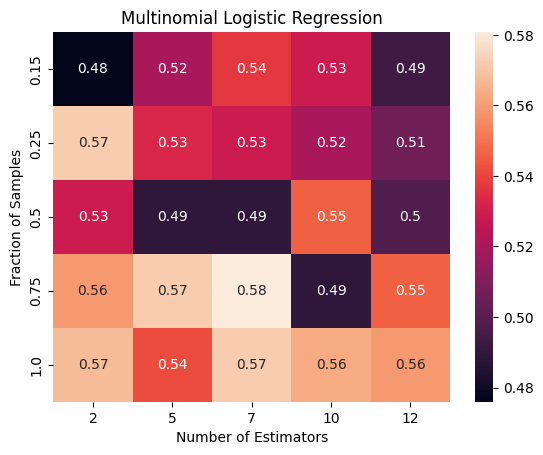

MLP


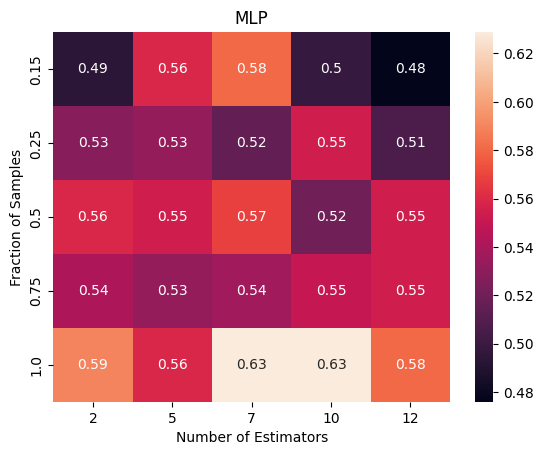

Decision Tree


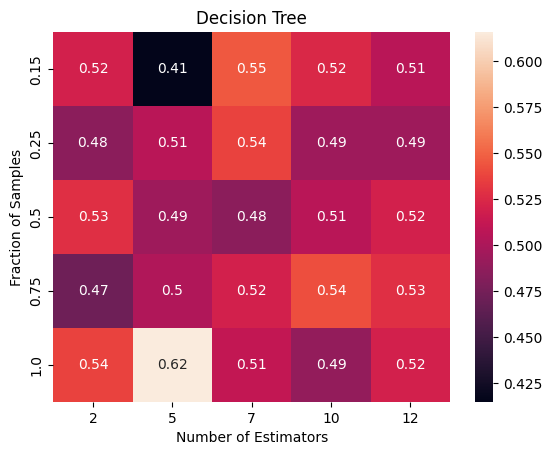

In [16]:
print("Multinomial Logistic Regression")
fraction = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [2,5,7,10,12]
accuracies = []
for f in fraction:
    for n in n_estimators:
        base_estimator = MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False)
        model = Bagging_classifier(base_estimator, n, f, True, 'hard', verbose=False)
        model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
        a,f1,p,r = model.test(x_test_wine, y_test_wine)
        accuracies.append(a)
accuracies = np.array(accuracies).reshape(5, 5)
import seaborn as sns
df = pd.DataFrame(accuracies, index=fraction, columns=n_estimators)
sns.heatmap(df, annot=True)
plt.xlabel("Number of Estimators")
plt.ylabel("Fraction of Samples")
plt.title("Multinomial Logistic Regression")
plt.show()

# MLP
print("MLP")
accuracies = []
for f in fraction:
    for n in n_estimators:
        base_estimator = MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False)
        model = Bagging_classifier(base_estimator, n, f, True, 'hard', verbose=False)
        model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
        a,f1,p,r = model.test(x_test_wine, y_test_wine)
        accuracies.append(a)
accuracies = np.array(accuracies).reshape(5, 5)
df = pd.DataFrame(accuracies, index=fraction, columns=n_estimators)
sns.heatmap(df, annot=True)
plt.xlabel("Number of Estimators")
plt.ylabel("Fraction of Samples")
plt.title("MLP")
plt.show()

print("Decision Tree")
accuracies = []
for f in fraction:
    for n in n_estimators:
        base_estimator = DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
        model = Bagging_classifier(base_estimator, n, f, True, 'hard', verbose=False)
        model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
        a,f1,p,r = model.test(x_test_wine, y_test_wine)
        accuracies.append(a)
accuracies = np.array(accuracies).reshape(5, 5)
df = pd.DataFrame(accuracies, index=fraction, columns=n_estimators)
sns.heatmap(df, annot=True)
plt.xlabel("Number of Estimators")
plt.ylabel("Fraction of Samples")
plt.title("Decision Tree")
plt.show()

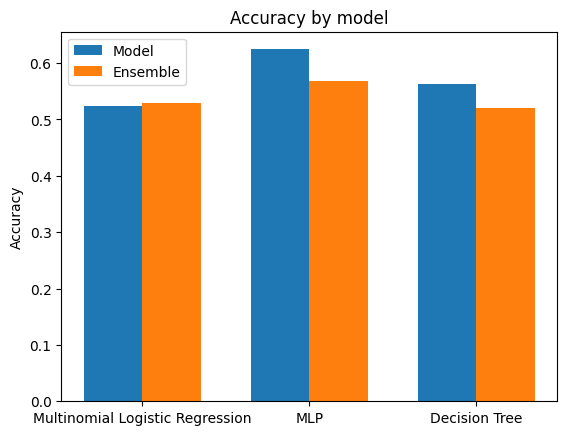

In [109]:
acc_model = []
acc_ensemnle = []

# Multinomial Logistic Regression
base_estimator = MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False)
base_estimator.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
acc_model.append(base_estimator.score(x_test_wine, y_test_wine))
base_estimator = MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False)
model = Bagging_classifier(base_estimator, 10, 0.75, True, 'hard', verbose=False)
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
a,f1,p,r = model.test(x_test_wine, y_test_wine)
acc_ensemnle.append(a)

# MLP
base_estimator = MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False)
base_estimator.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
acc_model.append(base_estimator.score(x_test_wine, y_test_wine))
base_estimator = MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False)
model = Bagging_classifier(base_estimator, 10, 0.75, True, 'hard', verbose=False)
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
a,f1,p,r = model.test(x_test_wine, y_test_wine)
acc_ensemnle.append(a)

# Decision Tree
base_estimator = DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
base_estimator.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
acc_model.append(base_estimator.score(x_test_wine, y_test_wine))
base_estimator = DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
model = Bagging_classifier(base_estimator, 12, 1, True, 'hard', verbose=False)
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
a,f1,p,r = model.test(x_test_wine, y_test_wine)
acc_ensemnle.append(a)

# plot histogram
x = np.arange(3)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, acc_model, width, label='Model')
rects2 = ax.bar(x + width/2, acc_ensemnle, width, label='Ensemble')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model')
ax.set_xticks(x)
ax.set_xticklabels(['Multinomial Logistic Regression', 'MLP', 'Decision Tree'])
ax.legend()
plt.show()

In [9]:
base_estimators = [MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False), MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False), DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)]
base_Models = ['Multinomial Logistic Regression', 'MLP', 'Decision Tree']
n_estimators = [2,5,7,10,12]
fraction = [0.15, 0.25, 0.5, 0.75, 1.0]
voting = ['hard', 'soft']
replace = [True, False]
best_model = None

i = 0
for base_estimator in base_estimators:
    for n in n_estimators:
        for f in fraction:
            for v in voting:
                for r in replace:
                    model = Bagging_classifier(base_estimator, n, f, r, v, verbose=False)
                    model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
                    a,f1,p,re = model.test(x_test_wine, y_test_wine)
                    print("Base Estimator: {0}, Number of Estimators: {1}, Fraction: {2}, Voting: {3}, Replacement: {4}, Accuracy: {5:.4f}".format(base_Models[i], n, f, v, r, a))
                    if best_model is None:
                        best_model = model
                    else:
                        if model.accuracy > best_model.accuracy:
                            best_model = model
    i += 1

Base Estimator: Multinomial Logistic Regression, Number of Estimators: 2, Fraction: 0.15, Voting: hard, Replacement: True, Accuracy: 0.4847
Base Estimator: Multinomial Logistic Regression, Number of Estimators: 2, Fraction: 0.15, Voting: hard, Replacement: False, Accuracy: 0.5284
Base Estimator: Multinomial Logistic Regression, Number of Estimators: 2, Fraction: 0.15, Voting: soft, Replacement: True, Accuracy: 0.5240
Base Estimator: Multinomial Logistic Regression, Number of Estimators: 2, Fraction: 0.15, Voting: soft, Replacement: False, Accuracy: 0.4978
Base Estimator: Multinomial Logistic Regression, Number of Estimators: 2, Fraction: 0.25, Voting: hard, Replacement: True, Accuracy: 0.5415
Base Estimator: Multinomial Logistic Regression, Number of Estimators: 2, Fraction: 0.25, Voting: hard, Replacement: False, Accuracy: 0.5677
Base Estimator: Multinomial Logistic Regression, Number of Estimators: 2, Fraction: 0.25, Voting: soft, Replacement: True, Accuracy: 0.5808
Base Estimator: M

In [34]:
# metrics for best model
# Best_bagging model : Base Estimator: MLP, Number of Estimators: 2, Fraction: 0.75, Voting: soft, Replacement: False, Accuracy: 0.6550
best_bagging_model = Bagging_classifier(MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False), 2, 0.75, False, 'soft')
best_bagging_model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
best_bagging_model.test(x_test_wine, y_test_wine)

Validation Accuracy: 0.5326
F1 Score: 0.5117
Precision: 0.4949
Recall: 0.5326
Test Accuracy: 0.5677
F1 Score: 0.5541
Precision: 0.5424
Recall: 0.5677


(0.5676855895196506,
 0.5540716024718638,
 0.5424424672993801,
 0.5676855895196506)

##### STACKING CLASSIFIER

In [67]:
class Stacking_Classifier:
    def __init__(self, level_0, level_1, n_folds = None, hold_out=None, method='stacking', verbose=True):
        self.level_0 = level_0
        self.level_1 = level_1
        self.n_folds = n_folds
        self.hold_out = hold_out
        self.models = []
        self.accuracies = []
        self.accuracy = None
        self.f1 = None
        self.precision = None
        self.recall = None
        self.method = method
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        if self.method == 'stacking':
            self.fit_stacking(x, y, x_val, y_val)
        elif self.method == 'blending':
            self.fit_blending(x, y, x_val, y_val)
        else:
            raise ValueError("Method must be 'stacking' or 'blending'")
        return self
    
    def fit_stacking(self, x, y, x_val, y_val):
        models_level_0 = []
        x_train_level_1 = []
        y_train_level_1 = []
        kf = KFold(n_splits=self.n_folds)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            columns = []
            for model in self.level_0:
                model.fit(x_train, y_train, x_val, y_val)
                models_level_0.append(model)
                predict = model.predict(x_test)
                columns.append(predict)
            columns = np.array(columns).T
            x_train_level_1.append(columns)
            y_train_level_1.append(y_test)
        x_train_level_1 = np.concatenate(x_train_level_1, axis=0)
        y_train_level_1 = np.concatenate(y_train_level_1, axis=0)
        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = train_test_split(x_train_level_1, y_train_level_1, test_size=0.1)
        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)
        for model in self.level_0:
            model.fit(x, y, x_val, y_val)
            self.models.append(model)
            self.accuracies.append(model.score(x_val, y_val))
        self.accuracies.append(self.level_1.score(x_val_level_1, y_val_level_1))
        self.models.append(self.level_1)
        y_pred = self.predict(x_val)
        self.accuracy = accuracy_score(y_val, y_pred)
        self.f1 = f1_score(y_val, y_pred, average='weighted',zero_division=0)
        self.precision = precision_score(y_val, y_pred, average='weighted',zero_division=0)
        self.recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Validation Accuracy: {0:.4f}".format(self.accuracy))
            print("F1 Score: {0:.4f}".format(self.f1))
            print("Precision: {0:.4f}".format(self.precision))
            print("Recall: {0:.4f}".format(self.recall))
        return self
    
    def fit_blending(self, x, y, x_val, y_val):
        x_train_level_1 = []
        y_train_level_1 = []
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=self.hold_out)
        for model in self.level_0:
            model.fit(x_train, y_train, x_val, y_val)
            self.models.append(model)
            self.accuracies.append(model.score(x_val, y_val))
            x_train_level_1.append(model.predict(x_test))
        y_train_level_1.append(y_test)
        x_train_level_1 = np.array(x_train_level_1).T
        y_train_level_1 = np.concatenate(y_train_level_1, axis=0)
        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = train_test_split(x_train_level_1, y_train_level_1, test_size=0.1)
        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)
        self.accuracies.append(self.level_1.score(x_val_level_1, y_val_level_1))
        self.models.append(self.level_1)
        y_pred = self.predict(x_val)
        self.accuracy = accuracy_score(y_val, y_pred)
        self.f1 = f1_score(y_val, y_pred, average='weighted',zero_division=0)
        self.precision = precision_score(y_val, y_pred, average='weighted',zero_division=0)
        self.recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Validation Accuracy: {0:.4f}".format(self.accuracy))
            print("F1 Score: {0:.4f}".format(self.f1))
            print("Precision: {0:.4f}".format(self.precision))
            print("Recall: {0:.4f}".format(self.recall))
        return self
    
    def predict(self, x):
        columns = []
        for model in self.models[:-1]:
            predict = model.predict(x)
            columns.append(predict)
        columns = np.array(columns).T
        return self.models[-1].predict(columns)
    
    def test(self, x, y):
        y_pred = self.predict(x)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted',zero_division=0)
        precision = precision_score(y, y_pred, average='weighted',zero_division=0)
        recall = recall_score(y, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Test Accuracy: {0:.4f}".format(accuracy))
            print("F1 Score: {0:.4f}".format(f1))
            print("Precision: {0:.4f}".format(precision))
            print("Recall: {0:.4f}".format(recall))
        return accuracy, f1, precision, recall

In [20]:
level_0 = [MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False), MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False), DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)]
level_1 = MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False)
print("Stacking")
model = Stacking_Classifier(level_0, level_1, n_folds=5, method='stacking')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)
print("Blending")
model = Stacking_Classifier(level_0, level_1, hold_out=0.2, method='blending')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)

Stacking
Validation Accuracy: 0.4891
F1 Score: 0.4229
Precision: 0.3967
Recall: 0.4891
Test Accuracy: 0.4367
F1 Score: 0.3766
Precision: 0.3847
Recall: 0.4367
Blending
Validation Accuracy: 0.4891
F1 Score: 0.4303
Precision: 0.3976
Recall: 0.4891
Test Accuracy: 0.4105
F1 Score: 0.3549
Precision: 0.3883
Recall: 0.4105


(0.4104803493449782,
 0.35487023675480717,
 0.3883040727207914,
 0.4104803493449782)

In [24]:
level_0 = [MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False), MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False), DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)]
level_1 = DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
print("Stacking")
model = Stacking_Classifier(level_0, level_1, n_folds=5, method='stacking')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)
print("Blending")
model = Stacking_Classifier(level_0, level_1, hold_out=0.2, method='blending')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)

Stacking
Validation Accuracy: 0.5978
F1 Score: 0.5792
Precision: 0.5703
Recall: 0.5978
Test Accuracy: 0.6070
F1 Score: 0.5973
Precision: 0.5928
Recall: 0.6070
Blending
Validation Accuracy: 0.5326
F1 Score: 0.5017
Precision: 0.6016
Recall: 0.5326
Test Accuracy: 0.5590
F1 Score: 0.5383
Precision: 0.5494
Recall: 0.5590


(0.5589519650655022,
 0.5383414764268767,
 0.5494492159185334,
 0.5589519650655022)

In [19]:
# finding best performing stacking model
level_0 = [MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False), MLPClassifier(learning_rate=0.1, epochs=3000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=20, hidden_layers=3, verbose=False), DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)]
level_1 = [MultinomialLogisticRegression(learning_rate=0.1, max_iter=3000, verbose=False), DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)]
level_0_Models = ['Multinomial Logistic Regression', 'MLP', 'Decision Tree']
level_1_Models = ['Multinomial Logistic Regression', 'Decision Tree']
n_folds = [2,3,5]
hold_out = [0.15, 0.25, 0.5, 0.75]
method = ['stacking', 'blending']
# best parameters
best_model = None
best_level_1 = None
best_n_folds = None
best_hold_out = None
best_accuracy = None
best_method = None
for l1 in level_1:
    for m in method:
        if m == 'stacking':
            for n in n_folds:
                model = Stacking_Classifier(level_0, l1, n_folds=n, method=m, verbose=False)
                model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
                a,f1,p,r = model.test(x_test_wine, y_test_wine)
                print("Level 1: {0}, Method: {1}, Number of Folds: {2}, Accuracy: {3:.4f}".format(level_1_Models[level_1.index(l1)], m, n, a))
                if best_model is None:
                    best_model = model
                    best_level_1 = l1
                    best_n_folds = n
                    best_accuracy = a
                    best_method = m
                else:
                    if a > best_accuracy:
                        best_model = model
                        best_level_1 = l1
                        best_n_folds = n
                        best_accuracy = a
                        best_method = m
        elif m == 'blending':
            for h in hold_out:
                model = Stacking_Classifier(level_0, l1, hold_out=h, method=m, verbose=False)
                model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
                a,f1,p,r = model.test(x_test_wine, y_test_wine)
                print("Level 1: {0}, Method: {1}, Hold Out: {2}, Accuracy: {3:.4f}".format(level_1_Models[level_1.index(l1)], m, h, a))
                if best_model is None:
                    best_model = model
                    best_level_1 = l1
                    best_hold_out = h
                    best_accuracy = a
                    best_method = m
                else:
                    if a > best_accuracy:
                        best_model = model
                        best_level_1 = l1
                        best_hold_out = h
                        best_accuracy = a
                        best_method = m

# metrics for best model
print("Best hyperparameters")
print("Level 1: {0}, Method: {1}, Number of Folds: {2}, Accuracy: {3:.4f}, hold_out: {4}".format(level_1_Models[level_1.index(best_level_1)], best_method, best_n_folds, best_accuracy,best_hold_out))

Level 1: Multinomial Logistic Regression, Method: stacking, Number of Folds: 2, Accuracy: 0.5109
Level 1: Multinomial Logistic Regression, Method: stacking, Number of Folds: 3, Accuracy: 0.4061
Level 1: Multinomial Logistic Regression, Method: stacking, Number of Folds: 5, Accuracy: 0.4454
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.15, Accuracy: 0.4236
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.25, Accuracy: 0.5066
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.5, Accuracy: 0.4454
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.75, Accuracy: 0.5633
Level 1: Decision Tree, Method: stacking, Number of Folds: 2, Accuracy: 0.6245
Level 1: Decision Tree, Method: stacking, Number of Folds: 3, Accuracy: 0.5939
Level 1: Decision Tree, Method: stacking, Number of Folds: 5, Accuracy: 0.6376
Level 1: Decision Tree, Method: blending, Hold Out: 0.15, Accuracy: 0.5546
Level 1: Decision Tree, Me

In [33]:
# Best stacking model : Level 1: Decision Tree, Method: stacking, Number of Folds: 5, Accuracy: 0.6376, hold_out: None
best_stacking_model = Stacking_Classifier(level_0, DT_Classifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None), n_folds=5, method='stacking')
best_stacking_model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
best_stacking_model.test(x_test_wine, y_test_wine)

Validation Accuracy: 0.6304
F1 Score: 0.6038
Precision: 0.5813
Recall: 0.6304
Test Accuracy: 0.6157
F1 Score: 0.6018
Precision: 0.5926
Recall: 0.6157


(0.6157205240174672,
 0.6018318748525697,
 0.5926449182293004,
 0.6157205240174672)

- Training time of bagging classifier = 33 sec
- Accuracy of bagging classifier = 0.56
- Training time of stacking classifier = 114 sec
- Accuracy of stacking classifier = 0.61

##### RANDOM FOREST CLASSIFIER

In [68]:
# Random Forest
class RandomForestClassifier:
    def __init__(self, n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', verbose=True):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.models = []
        self.accuracies = []
        self.accuracy = None
        self.f1 = None
        self.precision = None
        self.recall = None
        self.features = []
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        for i in range(self.n_estimators):
            indices = np.random.randint(0, len(x), len(x))
            x_sample = x[indices]
            y_sample = y[indices]
            self.max_features = np.random.randint(1, x.shape[1])
            self.features.append(np.random.choice(x.shape[1], self.max_features, replace=False))
            x_sample = x_sample[:, self.features[i]]
            model = DT_Classifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)
            model.fit(x_sample, y_sample, x_val[:, self.features[i]], y_val)
            self.models.append(model)
            self.accuracies.append(model.score(x_val[:, self.features[i]], y_val))
        y_pred = self.predict(x_val)
        self.accuracy = accuracy_score(y_val, y_pred)
        self.f1 = f1_score(y_val, y_pred, average='weighted',zero_division=0)
        self.precision = precision_score(y_val, y_pred, average='weighted',zero_division=0)
        self.recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Validation Accuracy: {0:.4f}".format(self.accuracy))
            print("F1 Score: {0:.4f}".format(self.f1))
            print("Precision: {0:.4f}".format(self.precision))
            print("Recall: {0:.4f}".format(self.recall))
        return self
    
    def predict(self, x):
        y_pred = []
        for i in range(self.n_estimators):
            x_sample = x[:, self.features[i]]
            y_pred.append(self.models[i].predict(x_sample))
        y_pred = np.array(y_pred).T
        y_pred = np.array([np.bincount(y).argmax() for y in y_pred])
        return y_pred
    
    def test(self, x, y):
        y_pred = self.predict(x)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted',zero_division=0)
        precision = precision_score(y, y_pred, average='weighted',zero_division=0)
        recall = recall_score(y, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Test Accuracy: {0:.4f}".format(accuracy))
            print("F1 Score: {0:.4f}".format(f1))
            print("Precision: {0:.4f}".format(precision))
            print("Recall: {0:.4f}".format(recall))
        return accuracy, f1, precision, recall


In [42]:
model = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto')
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)

Validation Accuracy: 0.6196
F1 Score: 0.6013
Precision: 0.6185
Recall: 0.6196
Test Accuracy: 0.6550
F1 Score: 0.6374
Precision: 0.6327
Recall: 0.6550


(0.6550218340611353,
 0.6374022248238169,
 0.6327454408694877,
 0.6550218340611353)

In [39]:
# Finding best hyperparameters for random forest
n_estimators = [10, 50, 100, 200]
criterion = ['gini', 'entropy']
max_depth = [None, 2, 5, 10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
max_features = ['auto', 'sqrt', 'log2']
best_model = None
best_accuracy = None
best_n_estimators = None
best_criterion = None
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_max_features = None

for n in n_estimators:
    for c in criterion:
        for d in max_depth:
            for s in min_samples_split:
                for l in min_samples_leaf:
                    for f in max_features:
                        model = RandomForestClassifier(n_estimators=n, criterion=c, max_depth=d, min_samples_split=s, min_samples_leaf=l, max_features=f, verbose=False)
                        model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
                        a,f1,p,r = model.test(x_test_wine, y_test_wine)
                        print("Number of Estimators: {0}, Criterion: {1}, Max Depth: {2}, Min Samples Split: {3}, Min Samples Leaf: {4}, Max Features: {5}, Accuracy: {6:.4f}".format(n, c, d, s, l, f, a))
                        if best_model is None:
                            best_model = model
                            best_accuracy = a
                            best_n_estimators = n
                            best_criterion = c
                            best_max_depth = d
                            best_min_samples_split = s
                            best_min_samples_leaf = l
                            best_max_features = f
                        else:
                            if a > best_accuracy:
                                best_model = model
                                best_accuracy = a
                                best_n_estimators = n
                                best_criterion = c
                                best_max_depth = d
                                best_min_samples_split = s
                                best_min_samples_leaf = l
                                best_max_features = f

# metrics for best model
print("Best hyperparameters")
print("Number of Estimators: {0}, Criterion: {1}, Max Depth: {2}, Min Samples Split: {3}, Min Samples Leaf: {4}, Max Features: {5}, Accuracy: {6:.4f}".format(best_n_estimators, best_criterion, best_max_depth, best_min_samples_split, best_min_samples_leaf, best_max_features, best_accuracy))

Number of Estimators: 10, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 1, Max Features: auto, Accuracy: 0.6157
Number of Estimators: 10, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 1, Max Features: sqrt, Accuracy: 0.5939
Number of Estimators: 10, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 1, Max Features: log2, Accuracy: 0.6157
Number of Estimators: 10, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 2, Max Features: auto, Accuracy: 0.6288
Number of Estimators: 10, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 2, Max Features: sqrt, Accuracy: 0.6332
Number of Estimators: 10, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 2, Max Features: log2, Accuracy: 0.6157
Number of Estimators: 10, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 5, Max Features: auto, Accuracy: 0.6157
Number of Estimators

In [50]:
# best hyperparameters : Number of Estimators: 50, Criterion: gini, Max Depth: None, Min Samples Split: 2, Min Samples Leaf: 1, Max Features: auto, Accuracy: 0.6987
best_random_forest_model = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto')
best_random_forest_model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
best_random_forest_model.test(x_test_wine, y_test_wine)

Validation Accuracy: 0.6196
F1 Score: 0.5984
Precision: 0.6098
Recall: 0.6196
Test Accuracy: 0.6769
F1 Score: 0.6597
Precision: 0.6563
Recall: 0.6769


(0.6768558951965066,
 0.6597020538643154,
 0.6563185480216048,
 0.6768558951965066)

##### ADABOOST CLASSIFIER

In [69]:
class Adaboost_Classifier:
    def __init__(self, n_estimators=10,verbose=True):
        self.n_estimators = n_estimators
        self.stumps = []
        self.alpha = []
        self.weights = []
        self.errors = []
        self.performance = []
        self.weights = []
        self.weights.append(np.ones(len(x_train_wine)) / len(x_train_wine))
        self.weights = np.array(self.weights)
        self.features = []
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(x), len(x), p=self.weights[-1])
            a = x[indices]
            b = y[indices]
            stump = self.create_stump(a, b,x_val,y_val)
            self.stumps.append(stump)
            input = a[:,self.features[-1]].reshape(-1,1)
            error = self.calculate_error(stump, input, b)
            self.errors.append(error)
            performance = self.calculate_performance(error)
            self.performance.append(performance)
            alpha = self.calculate_alpha(performance)
            self.alpha.append(alpha)
            new_weights = self.update_weights(alpha, stump, input, b)
            self.weights = np.vstack((self.weights, new_weights))
        y_pred = self.predict(x_val)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted',zero_division=0)
        precision = precision_score(y_val, y_pred, average='weighted',zero_division=0)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Validation Accuracy: {0:.4f}".format(accuracy))
            print("F1 Score: {0:.4f}".format(f1))
            print("Precision: {0:.4f}".format(precision))
            print("Recall: {0:.4f}".format(recall))
        return self
    

    def predict(self, x):
        y_pred = []
        for i in range(len(x)):
            predictions = []
            for j in range(self.n_estimators):
                input = x[i][self.features[j]]
                predictions.append(self.stumps[j].predict(input.reshape(1, -1))[0])
            y_pred.append(np.bincount(predictions).argmax())
        return y_pred
    
    def score(self, x, y):
        y_pred = self.predict(x)
        accuracy = np.sum(y_pred == y) / len(y)
        return accuracy

    def create_stump(self, x, y,x_val,y_val):
        stumps = []
        errors = []
        features = []
        for i in range(x.shape[1]):
            stump = DT_Classifier(criterion='gini', max_depth=1, min_samples_split=2, min_samples_leaf=1, max_features=1)
            stump.fit(x[:, i].reshape(-1, 1), y, x_val[:, i].reshape(-1, 1), y_val)
            stumps.append(stump)
            features.append(i)
            error = self.calculate_error(stump, x[:, i].reshape(-1, 1), y)
            errors.append(error)
        errors = np.array(errors)
        features = np.array(features)
        self.features.append(features[np.argmin(errors)])
        stump = stumps[np.argmin(errors)]
        return stump

    def calculate_error(self, stump, x, y):
        y_pred = stump.predict(x)
        error = np.sum(self.weights[-1] * (y_pred != y))

        return error
    
    def calculate_performance(self, error):
        return 1 - error
    
    def calculate_alpha(self, performance):
        return 0.5 * np.log((performance) / (1 - performance))
    
    def update_weights(self, alpha, stump, x, y):
        y_pred = stump.predict(x)
        new_weights = []
        for i in range(len(self.weights[-1])):
            if y_pred[i] != y[i]:
                new_weights.append(self.weights[-1][i] * np.exp(alpha))
            else:
                new_weights.append(self.weights[-1][i] * np.exp(-alpha))
        new_weights = np.array(new_weights)
        new_weights = new_weights / np.sum(new_weights)
        self.weights = np.vstack((self.weights, new_weights))
        return new_weights
    
    def test(self, x, y):
        y_pred = self.predict(x)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted',zero_division=0)
        precision = precision_score(y, y_pred, average='weighted',zero_division=0)
        recall = recall_score(y, y_pred, average='weighted', zero_division=0)
        if self.verbose:
            print("Test Accuracy: {0:.4f}".format(accuracy))
            print("F1 Score: {0:.4f}".format(f1))
            print("Precision: {0:.4f}".format(precision))
            print("Recall: {0:.4f}".format(recall))
        return accuracy, f1, precision, recall    

In [52]:
model = Adaboost_Classifier(n_estimators=10)
model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
model.test(x_test_wine, y_test_wine)

Validation Accuracy: 0.5326
F1 Score: 0.4688
Precision: 0.4386
Recall: 0.5326
Test Accuracy: 0.5721
F1 Score: 0.5167
Precision: 0.4836
Recall: 0.5721


(0.5720524017467249, 0.516673569369009, 0.4835554122537097, 0.5720524017467249)

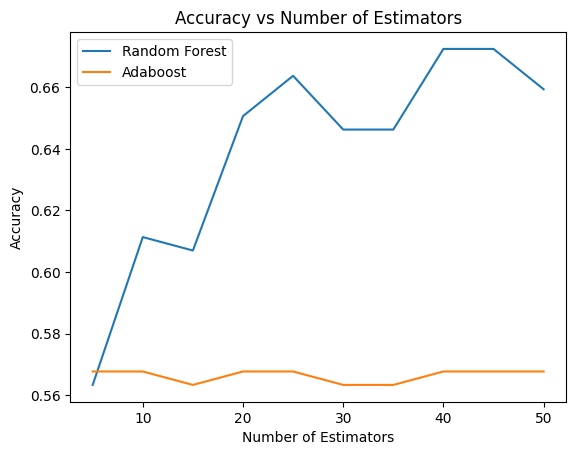

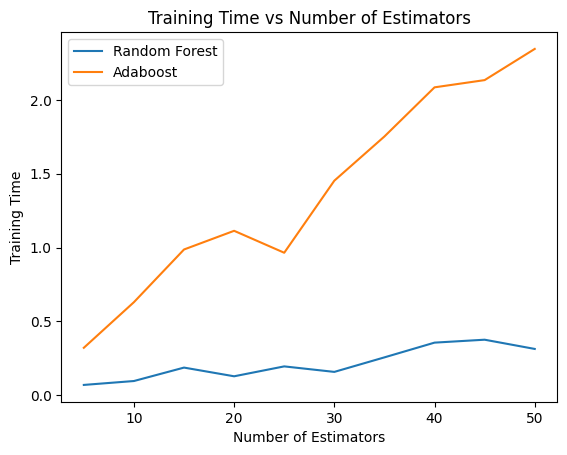

In [56]:
# changing number of estimators for adaboost and random forest and plotting accuracy and training time
import time
accuracy_rf = []
accuracy_ab = []
time_rf = []
time_ab = []

n_estimators = [5,10,15,20,25,30,35,40,45,50]
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', verbose=False)
    start = time.time()
    model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
    a,f1,p,r = model.test(x_test_wine, y_test_wine)
    end = time.time()
    accuracy_rf.append(a)
    time_rf.append(end-start)

    model = Adaboost_Classifier(n_estimators=n,verbose=False)
    start = time.time()
    model.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
    a,f1,p,r = model.test(x_test_wine, y_test_wine)
    end = time.time()
    accuracy_ab.append(a)
    time_ab.append(end-start)

plt.plot(n_estimators, accuracy_rf, label='Random Forest')
plt.plot(n_estimators, accuracy_ab, label='Adaboost')
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
plt.legend()
plt.show()

plt.plot(n_estimators, time_rf, label='Random Forest')
plt.plot(n_estimators, time_ab, label='Adaboost')
plt.xlabel("Number of Estimators")
plt.ylabel("Training Time")
plt.title("Training Time vs Number of Estimators")
plt.legend()
plt.show()

Random Forest
Misclassified Samples
(array([  1,   3,   4,   5,   6,   8,  11,  15,  16,  19,  21,  24,  26,
        32,  33,  34,  36,  37,  40,  41,  44,  46,  49,  52,  53,  54,
        55,  56,  57,  62,  65,  69,  70,  72,  73,  77,  82,  83,  84,
        88,  91,  92,  96,  97,  99, 100, 107, 113, 114, 116, 117, 118,
       128, 133, 134, 141, 142, 144, 150, 151, 155, 158, 159, 163, 167,
       171, 173, 177, 179, 185, 189, 193, 197, 200, 203, 212, 216, 219,
       220, 223, 224, 228]),)
Number of Misclassified Samples: 82
Adaboost
Misclassified Samples
(array([  1,   2,   3,   5,  10,  14,  15,  17,  23,  24,  26,  29,  31,
        33,  36,  37,  40,  44,  50,  52,  53,  55,  57,  58,  62,  65,
        69,  70,  76,  79,  83,  84,  89,  90,  91,  92,  96,  97,  99,
       100, 106, 107, 109, 110, 113, 114, 117, 122, 123, 125, 128, 132,
       133, 134, 135, 137, 138, 140, 142, 144, 150, 151, 152, 158, 159,
       160, 163, 164, 166, 167, 168, 173, 176, 177, 178, 179, 180, 183,
 

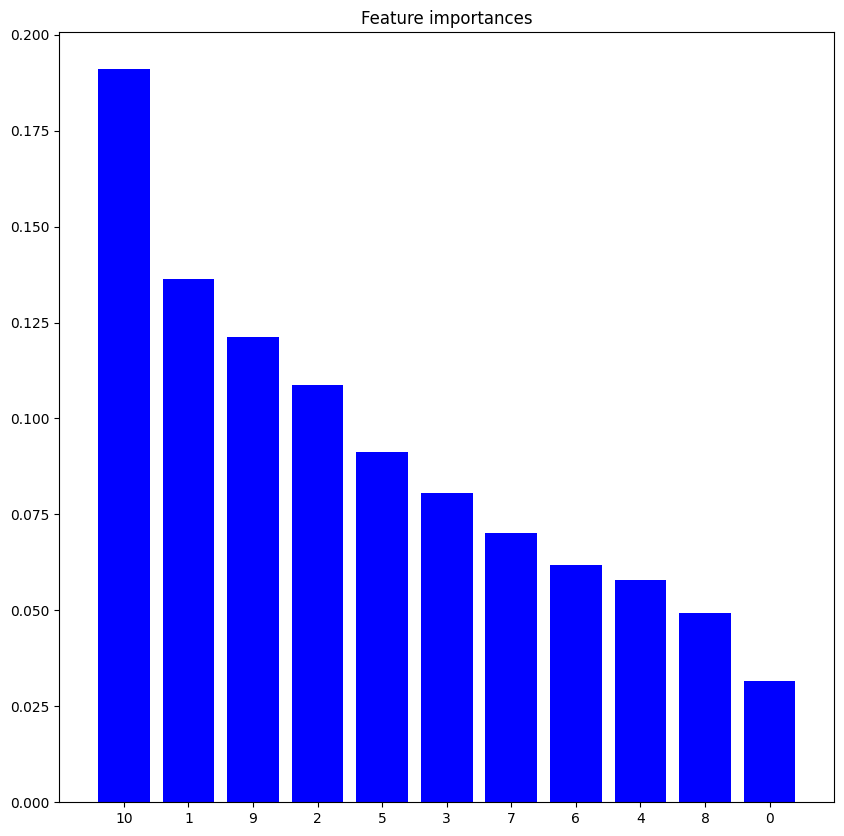

In [74]:
model1 = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', verbose=False)
model1.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
y_pred = model1.predict(x_test_wine)
misclassified_samples1 = np.where(y_test_wine != y_pred)
print("Random Forest")
print("Misclassified Samples")
print(misclassified_samples1)
print("Number of Misclassified Samples: {0}".format(len(misclassified_samples1[0])))

model2 = Adaboost_Classifier(n_estimators=50,verbose=False)
model2.fit(x_train_wine, y_train_wine, x_val_wine, y_val_wine)
y_pred = model2.predict(x_test_wine)
misclassified_samples2 = np.where(y_test_wine != y_pred)
print("Adaboost")
print("Misclassified Samples")
print(misclassified_samples2)
print("Number of Misclassified Samples: {0}".format(len(misclassified_samples2[0])))

common_misclassified_samples = np.intersect1d(misclassified_samples1, misclassified_samples2)
print("Common Misclassified Samples")
print(common_misclassified_samples)
print("Number of Common Misclassified Samples: {0}".format(len(common_misclassified_samples)))

model = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
model.fit(x_train_wine, y_train_wine)
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]
print("Feature ranking:")
for f in range(x_train_wine.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.bar(range(x_train_wine.shape[1]), importance[indices], color="b", align="center")
plt.xticks(range(x_train_wine.shape[1]), indices)
plt.xlim([-1, x_train_wine.shape[1]])
plt.show()

### HOUSING DATASET

In [2]:
df = pd.read_csv('HousingData.csv')
labels = df['MEDV'].values
x = df.drop(columns=['MEDV']).values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
x = imputer.fit_transform(x)

scaler = StandardScaler()
x = scaler.fit_transform(x)

normalizer = Normalizer()
x = normalizer.fit_transform(x)

X_train_Housing, X_test_Housing, y_train_Housing, y_test_Housing = train_test_split(x, labels, test_size=0.2, random_state=42)
X_train_Housing, X_val_Housing, y_train_Housing, y_val_Housing = train_test_split(X_train_Housing, y_train_Housing, test_size=0.1, random_state=42)
y_train_Housing = y_train_Housing.reshape(-1, 1)
y_test_Housing = y_test_Housing.reshape(-1, 1)
y_val_Housing = y_val_Housing.reshape(-1, 1)
print(X_train_Housing.shape)
print(y_train_Housing.shape)

(363, 13)
(363, 1)


#### MODELS FOR REGRESSION

##### MLP REGRESSOR

In [3]:
class MLPRegressor:
    def __init__(self, learning_rate=0.01, epochs=1000, activation='sigmoid', neurons = 10, optimizer='sgd', mini_batch_size=None, hidden_layers=1, verbose = True):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation = activation
        self.neurons = neurons
        self.loss = []
        self.val_loss = []
        self.weights = []
        self.bias = []
        self.optimizer = optimizer
        self.mini_batch_size = mini_batch_size
        self.hidden_layers = hidden_layers
        self.verbose = verbose

    # activation functions

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def gradient_sigmoid(self, x):
        return x * (1 - x)
    
    def gradient_tanh(self, x):
        return 1 - (x ** 2)
    
    def gradient_relu(self, x):
        return 1 * (x > 0)
    
    # optimizer functions

    def sgd(self, x, y):
        for i in range(len(x)):
            x_reshaped = x[i].reshape(1, -1)
            z = self.forward(x_reshaped)
            grad_w, grad_b = self.backward(x_reshaped, y[i], z)
            self.update_weights(x_reshaped, grad_w)
            self.update_bias(x_reshaped,grad_b)
    
    def bgd(self, x, y):
        z = self.forward(x)
        grad_w, grad_b = self.backward(x, y, z)
        self.update_weights(x, grad_w)
        self.update_bias(x,grad_b)

    def mbgd(self, x, y):
        for i in range(0, len(x), self.mini_batch_size):
            z = self.forward(x[i:i+self.mini_batch_size])
            grad_w, grad_b = self.backward(x[i:i+self.mini_batch_size], y[i:i+self.mini_batch_size], z)
            self.update_weights(x[i:i+self.mini_batch_size], grad_w)
            self.update_bias(x[i:i+self.mini_batch_size], grad_b)

    # forward and backward pass
    
    def forward(self, x):
        z = []
        for i in range(len(self.weights)):
            if i == 0:
                z.append(np.dot(x, self.weights[i]) + self.bias[i])
            else:
                z.append(np.dot(z[i-1], self.weights[i]) + self.bias[i])
            if i == len(self.weights) - 1:
                z[i] = self.relu(z[i])
                break
            if self.activation == 'sigmoid':
                z[i] = self.sigmoid(z[i])
            elif self.activation == 'tanh':
                z[i] = self.tanh(z[i])
            elif self.activation == 'relu':
                z[i] = self.relu(z[i])
        return z
    
    def backward(self, x, y, z):
        grad_w = []
        grad_b = []
        for i in reversed(range(len(self.weights))):
            if i == len(self.weights) - 1:
                error = z[i] - y
                grad = error * self.gradient_relu(z[i])
                grad_w.append(np.dot(z[i-1].T, error))
                grad_b.append(np.sum(error, axis=0, keepdims=True))
            elif i == 0:
                error = np.dot(grad, self.weights[i+1].T)
                if self.activation == 'sigmoid':
                    grad = error * self.gradient_sigmoid(z[i])
                elif self.activation == 'tanh':
                    grad = error * self.gradient_tanh(z[i])
                elif self.activation == 'relu':
                    grad = error * self.gradient_relu(z[i])
                grad_w.append(np.dot(x.T, grad))
                grad_b.append(np.sum(grad, axis=0, keepdims=True))
            else:
                error = np.dot(grad, self.weights[i+1].T)
                if self.activation == 'sigmoid':
                    grad = error * self.gradient_sigmoid(z[i])
                elif self.activation == 'tanh':
                    grad = error * self.gradient_tanh(z[i])
                elif self.activation == 'relu':
                    grad = error * self.gradient_relu(z[i])
                grad_w.append(np.dot(z[i-1].T, grad))
                grad_b.append(np.sum(grad, axis=0, keepdims=True))
        grad_w.reverse()
        grad_b.reverse()
        return grad_w, grad_b
    
    # update weights and bias

    def update_weights(self, x, grad_w):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grad_w[i]/len(x)
    
    def update_bias(self, x, grad_b):
        for i in range(len(self.bias)):
            self.bias[i] -= self.learning_rate * grad_b[i]/len(x)

    # fit and predict

    def fit(self, x, y, x_val, y_val):
        self.loss = []
        self.val_loss = []
        self.weights = []
        self.bias = []
        n_features = x.shape[1]
        # multiple hidden layers
        for i in range(self.hidden_layers):
            if i == 0:
                self.weights.append(np.random.randn(n_features, self.neurons))
                self.bias.append(np.zeros((1, self.neurons)))
            else:
                self.weights.append(np.random.randn(self.neurons, self.neurons))
                self.bias.append(np.zeros((1, self.neurons)))
        self.weights.append(np.random.randn(self.neurons, 1))
        self.bias.append(np.zeros((1, 1)))
        for i in range(self.epochs):
            if self.optimizer == 'sgd':
                self.sgd(x, y)
            elif self.optimizer == 'bgd':
                self.bgd(x, y)
            elif self.optimizer == 'mbgd':
                self.mbgd(x, y)
            else:
                raise ValueError("Optimizer must be 'sgd', 'bgd', or 'mbgd'")
            
            loss = self.mse_loss(x, y)
            val_loss = self.mse_loss(x_val, y_val)
            self.loss.append(loss)
            self.val_loss.append(val_loss)
            if self.verbose:
                print("Iteration: {0}, Loss: {1:.4f}, Val Loss: {2:.4f}".format(i+1, loss, val_loss))
        return self
    
    def predict(self, x):
        return self.forward(x)[-1]
    
    def mse_loss(self, x, y):
        y_pred = self.predict(x)
        loss = np.mean(1/2*(y_pred - y) ** 2)
        return loss

    def plot_loss(self):
        plt.plot(self.loss, label='loss')
        plt.plot(self.val_loss, label='val_loss')
        plt.title("Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# best model : MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2)

##### LINEAR REGRESSOR

In [4]:
# Linear Regression
class LinearRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, verbose=True):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss = []
        self.weights = None
        self.bias = None
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        n_features = x.shape[1]
        self.weights = np.random.randn(n_features, 1)
        self.bias = np.zeros((1, 1))
        for i in range(self.epochs):
            y_pred = self.predict(x)
            loss = self.mse_loss(y_pred, y)
            self.loss.append(loss)
            grad_w, grad_b = self.gradient(x, y, y_pred)
            self.update_weights(grad_w)
            self.update_bias(grad_b)
            val_loss = self.mse_loss(self.predict(x_val), y_val)
            if self.verbose:
                print("Iteration: {0}, Loss: {1:.4f}, Val Loss: {2:.4f}".format(i+1, loss, val_loss))
        return self
    
    def predict(self, x):
        return np.dot(x, self.weights) + self.bias
    
    def mse_loss(self, y_pred, y):
        # control overflow
        y_pred = np.clip(y_pred, -100, 100)
        loss = np.mean((y_pred - y) ** 2)
        return loss
    
    def gradient(self, x, y, y_pred):
        # control overflow
        grad_w = 2 * np.dot(x.T, (y_pred - y)) / len(x)
        grad_b = 2 * np.sum(y_pred - y) / len(x)
        grad_w = np.clip(grad_w, -1, 1)
        return grad_w, grad_b
    
    def update_weights(self, grad_w):
        self.weights -= self.learning_rate * grad_w

    def update_bias(self, grad_b):
        self.bias -= self.learning_rate * grad_b
    
    def plot_loss(self):
        plt.plot(self.loss)
        plt.title("Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()

# https://wandb.ai/shravya1051/ass4/sweeps/miwutar9
# best hyperparameters: learning_rate = 0.001, epochs = 8000

##### DECISION TREE REGRESSOR

In [5]:
# Build Decision Tree Regressor for Housing dataset using sklearn
class DT_Regressor:
    def __init__(self, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.model = DecisionTreeRegressor(criterion=self.criterion, max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)

    def fit(self, x, y, x_val, y_val):
        self.model.fit(x, y)
        return self
    
    def predict(self, x):
        return self.model.predict(x)
    
    def score(self, x, y):
        return self.model.score(x, y)
    
    def plot(self):
        plt.figure(figsize=(20, 20))
        tree.plot_tree(self.model, filled=True, rounded=True)
        plt.show()

##### BAGGING REGRESSOR

In [6]:
class Bagging_Regressor:
    def __init__(self, base_estimator, n_estimators, fraction, bootstrap, voting, verbose=True):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.fraction = fraction
        self.n_samples = None
        self.bootstrap = bootstrap
        self.voting = voting
        self.models = []
        self.val_losses = []
        self.mse = None
        self.r2 = None
        self.rmse = None
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        self.n_samples = int(self.fraction * len(x))
        for i in range(self.n_estimators):
            if self.bootstrap:
                x_sample, y_sample = self.bootstrap_sampling(x, y)
            else:
                x_sample, y_sample = self.sampling_without_replacement(x, y)
            self.base_estimator.fit(x_sample, y_sample, x_val, y_val)
            self.models.append(self.base_estimator)
            val_loss = mean_squared_error(y_val, self.base_estimator.predict(x_val))
            self.val_losses.append(val_loss)
        if self.voting == 'hard':
            y_pred = self.hard_voting(x_val)
        elif self.voting == 'soft':
            y_pred = self.soft_voting(x_val)
        self.mse = mean_squared_error(y_val, y_pred)
        self.r2 = r2_score(y_val, y_pred)
        self.rmse = np.sqrt(self.mse)
        if self.verbose:
            print("Validation MSE : {0:.4f}".format(self.mse))
            print("Validation R2: {0:.4f}".format(self.r2))
            print("Validation RMSE: {0:.4f}".format(self.rmse))
        return self
    
    def predict(self, x):
        if self.voting == 'hard':
            y_pred = self.hard_voting(x)
        elif self.voting == 'soft':
            y_pred = self.soft_voting(x)
        return y_pred
    
    def bootstrap_sampling(self, x, y):
        indices = np.random.randint(0, len(x), self.n_samples)
        x_sample = x[indices]
        y_sample = y[indices]
        return x_sample, y_sample
    
    def sampling_without_replacement(self,x, y):
        indices = np.random.choice(len(x), self.n_samples, replace=False)
        x_sample = x[indices]
        y_sample = y[indices]
        return x_sample, y_sample
    
    def hard_voting(self,x):
        y_pred = []
        for i in range(len(x)):
            predictions = []
            for model in self.models:
                predictions.append(model.predict(x[i].reshape(1, -1))[0])
            y_pred.append(np.mean(predictions))
        return y_pred
    
    def soft_voting(self, x):
        y_pred = []
        for i in range(len(x)):
            predictions = []
            for model in self.models:
                predictions.append(model.predict(x[i].reshape(1, -1))[0])
            weights = [1/val_loss for val_loss in self.val_losses]
            y_pred.append(np.average(predictions, weights=weights, axis=0))
        return y_pred
    
    def test(self, x, y):
        y_pred = self.predict(x)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mse)
        if self.verbose:
            print("Test MSE: {0:.4f}".format(mse))
            print("Test R2: {0:.4f}".format(r2))
            print("Test RMSE: {0:.4f}".format(rmse))
        return mse, r2, rmse

In [56]:
base_estimator = LinearRegression(learning_rate=0.001, epochs=8000, verbose=False)
model = Bagging_Regressor(base_estimator, 10, 0.75, True, 'soft')
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)
model = Bagging_Regressor(base_estimator, 10, 0.75, True, 'hard')
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)

Validation MSE : 17.0975
Validation R2: 0.7390
Validation RMSE: 4.1349
Test MSE: 32.8589
Test R2: 0.5519
Test RMSE: 5.7323
Validation MSE : 19.9330
Validation R2: 0.6957
Validation RMSE: 4.4646
Test MSE: 31.8050
Test R2: 0.5663
Test RMSE: 5.6396


(31.80496602642616, 0.5662985781478931, 5.639589171777157)

In [57]:
base_estimator = MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False)
model = Bagging_Regressor(base_estimator, 10, 0.75, True, 'soft')
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)
model = Bagging_Regressor(base_estimator, 10, 0.75, True, 'hard')
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)

Validation MSE : 18.9419
Validation R2: 0.7109
Validation RMSE: 4.3522
Test MSE: 25.0049
Test R2: 0.6590
Test RMSE: 5.0005
Validation MSE : 20.4644
Validation R2: 0.6876
Validation RMSE: 4.5238
Test MSE: 25.4597
Test R2: 0.6528
Test RMSE: 5.0458


(25.459661925100516, 0.6528249215039079, 5.045756823817466)

Linear Regression


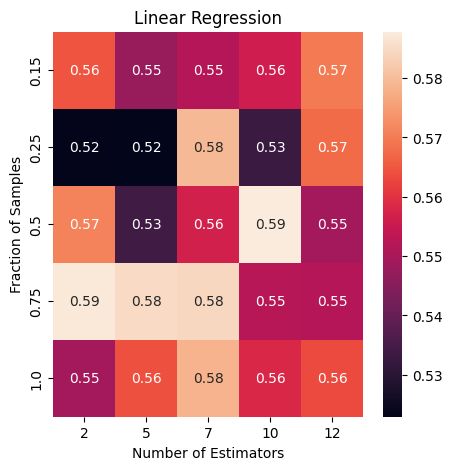

Decision Tree Regressor


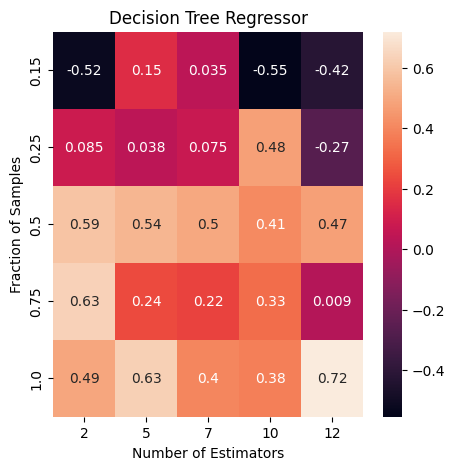

MLP Regressor


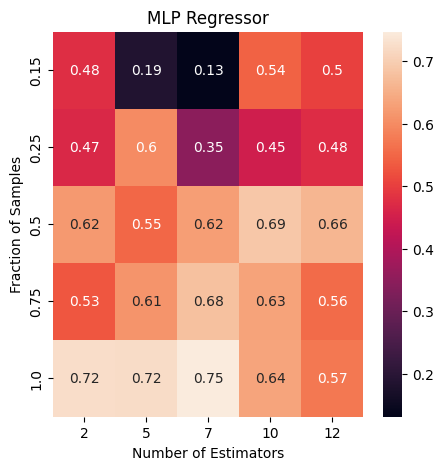

In [101]:
fraction = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [2,5,7,10,12]

print("Linear Regression")
r2s = []
for f in fraction:
    for n in n_estimators:
        model = Bagging_Regressor(LinearRegression(learning_rate=0.001, epochs=8000, verbose=False), n, f, True, 'hard', False)
        model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
        mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
        r2s.append(r2)
r2s = np.array(r2s).reshape(5, 5)
plt.figure(figsize=(5,5))
sns.heatmap(r2s, annot=True, xticklabels=n_estimators, yticklabels=fraction)
plt.title("Linear Regression")
plt.xlabel("Number of Estimators")
plt.ylabel("Fraction of Samples")
plt.show()

print("Decision Tree Regressor")
r2s = []
for f in fraction:
    for n in n_estimators:
        model = Bagging_Regressor(DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None), n, f, True, 'hard', False)
        model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
        mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
        r2s.append(r2)
r2s = np.array(r2s).reshape(5, 5)
plt.figure(figsize=(5,5))
sns.heatmap(r2s, annot=True, xticklabels=n_estimators, yticklabels=fraction)
plt.title("Decision Tree Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Fraction of Samples")
plt.show()

print("MLP Regressor")
r2s = []
for f in fraction:
    for n in n_estimators:
        model = Bagging_Regressor(MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False), n, f, True, 'hard', False)
        model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
        mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
        r2s.append(r2)
r2s = np.array(r2s).reshape(5, 5)
plt.figure(figsize=(5,5))
sns.heatmap(r2s, annot=True, xticklabels=n_estimators, yticklabels=fraction)
plt.title("MLP Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Fraction of Samples")
plt.show()

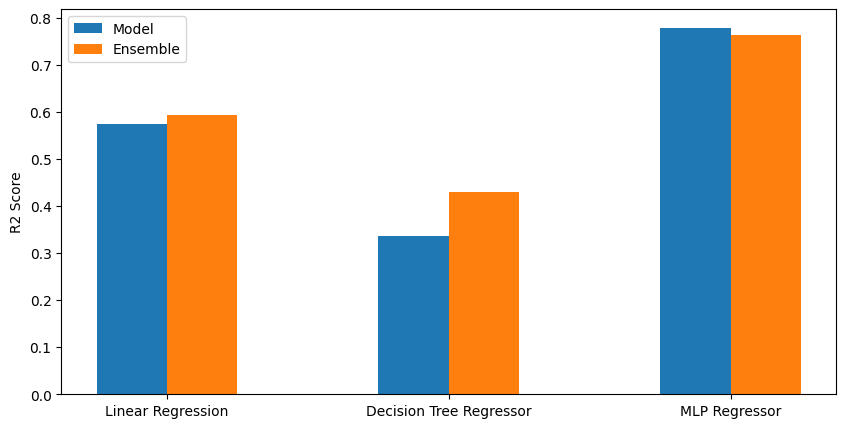

In [105]:
r2_model = []
r2_ensemble = []

# Linear Regression
model = LinearRegression(learning_rate=0.001, epochs=8000, verbose=False)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
y_pred = model.predict(X_test_Housing)
r2_model.append(r2_score(y_test_Housing, y_pred))

base_estimator = LinearRegression(learning_rate=0.001, epochs=8000, verbose=False)
model = Bagging_Regressor(base_estimator, 10, 0.5, True, 'hard', False)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
_,r,_ = model.test(X_test_Housing, y_test_Housing)
r2_ensemble.append(r)

# Decision Tree Regressor
model = DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
y_pred = model.predict(X_test_Housing)
r2_model.append(r2_score(y_test_Housing, y_pred))

base_estimator = DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
model = Bagging_Regressor(base_estimator, 12, 1, True, 'hard', False)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
_,r,_ = model.test(X_test_Housing, y_test_Housing)
r2_ensemble.append(r)

# MLP Regressor
model = MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
y_pred = model.predict(X_test_Housing)
r2_model.append(r2_score(y_test_Housing, y_pred))

base_estimator = MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False)
model = Bagging_Regressor(base_estimator, 7, 1, True, 'hard', False)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
_,r,_ = model.test(X_test_Housing, y_test_Housing)
r2_ensemble.append(r)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(3), r2_model, width=0.25, label='Model')
plt.bar(np.arange(3)+0.25, r2_ensemble, width=0.25, label='Ensemble')
plt.xticks(np.arange(3)+0.125, ['Linear Regression', 'Decision Tree Regressor', 'MLP Regressor'])
plt.ylabel("R2 Score")
plt.legend()
plt.show()

In [64]:
# finding best hyperparameters for bagging regressor
n_estimators = [2,5,7,10,12]
fraction = [0.15, 0.25, 0.5, 0.75, 1.0]
base_estimators = [LinearRegression(learning_rate=0.001, epochs=8000, verbose=False), DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None), MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False)]
base_estimator_names = ['Linear Regression', 'Decision Tree Regressor', 'MLP Regressor']
voting = ['hard', 'soft']
replace = [True, False]
best_model = None
best_r2 = None
best_n_estimators = None
best_fraction = None
best_mse = None
best_rmse = None
base_model_name = None
best_voting = None
best_replace = None

i = 0
for base_estimator in base_estimators:
    for n in n_estimators:
        for f in fraction:
            for v in voting:
                for r in replace:
                    model = Bagging_Regressor(base_estimator, n, f, r, v, False)
                    model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
                    mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
                    print("Base Estimator: {0}, Number of Estimators: {1}, Fraction: {2}, Voting: {3}, Replace: {4}, R2 Score: {5:.4f}, mse: {6}".format(base_estimator_names[i], n, f, v, r, r2,mse))
                    if best_model is None:
                        best_model = model
                        best_r2 = r2
                        best_n_estimators = n
                        best_fraction = f
                        best_mse = mse
                        best_rmse = rmse
                        base_model_name = base_estimator_names[i]
                        best_voting = v
                        best_replace = r
                    else:
                        if r2 > best_r2:
                            best_model = model
                            best_r2 = r2
                            best_n_estimators = n
                            best_fraction = f
                            best_mse = model.mse
                            best_rmse = model.rmse
                            base_model_name = base_estimator_names[i]
                            best_voting = v
                            best_replace = r
    i += 1

print("Best hyperparameters")
print("Base Estimator: {0}, Number of Estimators: {1}, Fraction: {2}, Voting: {3}, Replace: {4}, R2 Score: {5:.4f}, mse: {6}".format(base_model_name, best_n_estimators, best_fraction, best_voting, best_replace, best_r2, best_mse))


Base Estimator: Linear Regression, Number of Estimators: 2, Fraction: 0.15, Voting: hard, Replace: True, R2 Score: 0.5252, mse: 34.815323741581906
Base Estimator: Linear Regression, Number of Estimators: 2, Fraction: 0.15, Voting: hard, Replace: False, R2 Score: 0.5030, mse: 36.44511849619931
Base Estimator: Linear Regression, Number of Estimators: 2, Fraction: 0.15, Voting: soft, Replace: True, R2 Score: 0.5716, mse: 31.415183341234215
Base Estimator: Linear Regression, Number of Estimators: 2, Fraction: 0.15, Voting: soft, Replace: False, R2 Score: 0.5538, mse: 32.72384951745944
Base Estimator: Linear Regression, Number of Estimators: 2, Fraction: 0.25, Voting: hard, Replace: True, R2 Score: 0.5408, mse: 33.673582141825285
Base Estimator: Linear Regression, Number of Estimators: 2, Fraction: 0.25, Voting: hard, Replace: False, R2 Score: 0.4761, mse: 38.41978814100399
Base Estimator: Linear Regression, Number of Estimators: 2, Fraction: 0.25, Voting: soft, Replace: True, R2 Score: 0.5

In [66]:
# best hyperparameters : MLP Regressor, Number of Estimators: 10, Fraction: 1.0, Voting: soft, Replace: False, R2 Score: 0.7717, mse: 19.106703681819596
start = time.time()
best_bagging_model = Bagging_Regressor(MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False), 10, 1.0, False, 'soft')
best_bagging_model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
best_bagging_model.test(X_test_Housing, y_test_Housing)
end = time.time()
print("Training Time: {0:.4f}".format(end-start))

Validation MSE : 13.8672
Validation R2: 0.7883
Validation RMSE: 3.7239
Test MSE: 16.7352
Test R2: 0.7718
Test RMSE: 4.0909
Training Time: 7.8075


##### STACKING REGRESSOR

In [7]:
class Stacking_Regressor:
    def __init__(self, level_0, level_1, n_folds = None, hold_out=None, method='stacking',verbose=True):
        self.level_0 = level_0
        self.level_1 = level_1
        self.n_folds = n_folds
        self.hold_out = hold_out
        self.models = []
        self.val_losses = []
        self.mse = None
        self.r2 = None
        self.rmse = None
        self.method = method
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        if self.method == 'stacking':
            self.fit_stacking(x, y, x_val, y_val)
        elif self.method == 'blending':
            self.fit_blending(x, y, x_val, y_val)
        else:
            raise ValueError("Method must be 'stacking' or 'blending'")
        return self
    
    def fit_stacking(self, x, y, x_val, y_val):
        models_level_0 = []
        x_train_level_1 = []
        y_train_level_1 = []
        kf = KFold(n_splits=self.n_folds)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            columns = []
            for model in self.level_0:
                model.fit(x_train, y_train, x_val, y_val)
                models_level_0.append(model)
                predict = model.predict(x_test)
                predict = predict.reshape(-1)
                columns.append(predict)
            columns = np.array(columns).T
            x_train_level_1.append(columns)
            y_train_level_1.append(y_test)
        x_train_level_1 = np.concatenate(x_train_level_1, axis=0)
        y_train_level_1 = np.concatenate(y_train_level_1, axis=0)
        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = train_test_split(x_train_level_1, y_train_level_1, test_size=0.1)
        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)
        for model in self.level_0:
            model.fit(x, y, x_val, y_val)
            self.models.append(model)
            self.val_losses.append(mean_squared_error(y_val, model.predict(x_val)))
        self.val_losses.append(mean_squared_error(y_val_level_1, self.level_1.predict(x_val_level_1)))
        self.models.append(self.level_1)
        y_pred = self.predict(x_val)
        self.mse = mean_squared_error(y_val, y_pred)
        self.r2 = r2_score(y_val, y_pred)
        self.rmse = np.sqrt(self.mse)
        if self.verbose:
            print("Validation MSE: {0:.4f}".format(self.mse))
            print("Validation R2: {0:.4f}".format(self.r2))
            print("Validation RMSE: {0:.4f}".format(self.rmse))
        return self
    
    def fit_blending(self, x, y, x_val, y_val):
        x_train_level_1 = []
        y_train_level_1 = []
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=self.hold_out)
        for model in self.level_0:
            model.fit(x_train, y_train, x_val, y_val)
            self.models.append(model)
            self.val_losses.append(mean_squared_error(y_val, model.predict(x_val)))
            predict = model.predict(x_test)
            predict = predict.reshape(-1)
            x_train_level_1.append(predict)
        y_train_level_1.append(y_test)
        x_train_level_1 = np.array(x_train_level_1).T
        y_train_level_1 = np.concatenate(y_train_level_1, axis=0)
        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = train_test_split(x_train_level_1, y_train_level_1, test_size=0.1)
        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)
        self.val_losses.append(mean_squared_error(y_val_level_1, self.level_1.predict(x_val_level_1)))
        self.models.append(self.level_1)
        y_pred = self.predict(x_val)
        self.mse = mean_squared_error(y_val, y_pred)
        self.r2 = r2_score(y_val, y_pred)
        self.rmse = np.sqrt(self.mse)
        if self.verbose:
            print("Validation MSE: {0:.4f}".format(self.mse))
            print("Validation R2: {0:.4f}".format(self.r2))
            print("Validation RMSE: {0:.4f}".format(self.rmse))
        return self
    
    def predict(self, x):
        columns = []
        for model in self.models[:-1]:
            predict = model.predict(x)
            predict = predict.reshape(-1)
            columns.append(predict)
        columns = np.array(columns).T
        return self.models[-1].predict(columns)
    
    def test(self, x, y):
        y_pred = self.predict(x)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mse)
        if self.verbose:
            print("Test MSE: {0:.4f}".format(mse))
            print("Test R2: {0:.4f}".format(r2))
            print("Test RMSE: {0:.4f}".format(rmse))
        return mse, r2, rmse

In [92]:
level_0 = [LinearRegression(learning_rate=0.001, epochs=1000, verbose=False), MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False), DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)]
level_1 = DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
print("Stacking")
model = Stacking_Regressor(level_0, level_1, n_folds=5, method='stacking')
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)
print("Blending")
model = Stacking_Regressor(level_0, level_1, hold_out=0.2, method='blending')
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)

Stacking
Validation MSE: 52.4422
Validation R2: 0.1995
Validation RMSE: 7.2417
Test MSE: 27.3707
Test R2: 0.6268
Test RMSE: 5.2317
Blending
Validation MSE: 36.1856
Validation R2: 0.4477
Validation RMSE: 6.0154
Test MSE: 26.4387
Test R2: 0.6395
Test RMSE: 5.1419


(26.438725490196084, 0.6394741366009236, 5.141860119664487)

In [95]:
# finding best hyperparameters for stacking regressor
level_0 = [LinearRegression(learning_rate=0.001, epochs=1000, verbose=False), MLPRegressor(learning_rate=0.01, epochs=500, activation='tanh', neurons = 64, optimizer='bgd', mini_batch_size=10, hidden_layers=2, verbose=False), DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None)]
level_1 = [DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None), LinearRegression(learning_rate=0.001, epochs=1000, verbose=False)]
level_1_models = ['Decision Tree', 'Linear Regression']
n_folds = [2,3,5]
hold_out = [0.15, 0.25, 0.5, 0.75]
method = ['stacking', 'blending']
# best parameters
best_model = None
best_level_1 = None
best_n_folds = None
best_hold_out = None
best_method = None
best_mse = None
best_r2 = None

for l1 in level_1:
    for m in method:
        if m == 'stacking':
            for n in n_folds:
                model = Stacking_Regressor(level_0, l1, n,None,m,False)
                model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
                mse,r2,_ = model.test(X_test_Housing, y_test_Housing)
                print("Level 1: {0}, Method: {1}, Number of Folds: {2}, r2: {3:.4f}".format(level_1_Models[level_1.index(l1)], m, n, r2))
                if best_model is None:
                    best_model = model
                    best_level_1 = l1
                    best_n_folds = n
                    best_mse = mse
                    best_r2 = r2
                    best_method = m
                else:
                    if r2 > best_r2:
                        best_model = model
                        best_level_1 = l1
                        best_n_folds = n
                        best_mse = mse
                        best_r2 = r2
                        best_method = m
        elif m == 'blending':
            for h in hold_out:
                model = Stacking_Regressor(level_0, l1, None, h, m,False)
                model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
                mse,r2,_  = model.test(X_test_Housing, y_test_Housing)
                print("Level 1: {0}, Method: {1}, Hold Out: {2}, r2: {3:.4f}".format(level_1_Models[level_1.index(l1)], m, h, r2))
                if best_model is None:
                    best_model = model
                    best_level_1 = l1
                    best_hold_out = h
                    best_mse = mse
                    best_r2 = r2
                    best_method = m
                else:
                    if r2 > best_r2:
                        best_model = model
                        best_level_1 = l1
                        best_hold_out = h
                        best_mse = mse
                        best_r2 = r2
                        best_method = m

# metrics for best model
print("Best hyperparameters")
print("Level 1: {0}, Method: {1}, Number of Folds: {2}, r2: {3:.4f},mse: {4:.4f} ,hold_out: {5}".format(level_1_Models[level_1.index(best_level_1)], best_method, best_n_folds, best_r2,best_mse,best_hold_out))

Level 1: Multinomial Logistic Regression, Method: stacking, Number of Folds: 2, r2: 0.3311
Level 1: Multinomial Logistic Regression, Method: stacking, Number of Folds: 3, r2: 0.2247
Level 1: Multinomial Logistic Regression, Method: stacking, Number of Folds: 5, r2: 0.4718
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.15, r2: 0.5774
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.25, r2: -0.0144
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.5, r2: 0.4143
Level 1: Multinomial Logistic Regression, Method: blending, Hold Out: 0.75, r2: 0.3333
Level 1: Decision Tree, Method: stacking, Number of Folds: 2, r2: 0.6458
Level 1: Decision Tree, Method: stacking, Number of Folds: 3, r2: 0.2620
Level 1: Decision Tree, Method: stacking, Number of Folds: 5, r2: 0.7083
Level 1: Decision Tree, Method: blending, Hold Out: 0.15, r2: 0.7577
Level 1: Decision Tree, Method: blending, Hold Out: 0.25, r2: 0.6280
Level 1: Decision Tree

In [96]:
# Best stacking model Decision Tree, Method: stacking, Number of Folds: 2, r2: 0.7650,mse: 17.2366 ,hold_out: 0.5
start = time.time()
best_stacking_model = Stacking_Regressor(level_0,DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None),best_n_folds,best_hold_out,best_method)
best_stacking_model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
best_stacking_model.test(X_test_Housing, y_test_Housing)
end = time.time()
print("Training Time: {0:.4f}".format(end-start))

Validation MSE: 45.1739
Validation R2: 0.3105
Validation RMSE: 6.7212
Test MSE: 28.7737
Test R2: 0.6076
Test RMSE: 5.3641
Training Time: 1.5235


- Training time for bagging : 7.8075 sec
- r2 score of bagging : 0.7718
- Training time for stacking : 1.5235 sec
- r2 score of stacking : 0.6076

##### RANDOM FOREST REGRESSOR

In [8]:
class RandomForestRegressor:
    def __init__(self, n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto',verbose=True):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.models = []
        self.val_losses = []
        self.mse = None
        self.r2 = None
        self.rmse = None
        self.features = []
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        for i in range(self.n_estimators):
            indices = np.random.randint(0, len(x), len(x))
            x_sample = x[indices]
            y_sample = y[indices]
            self.max_features = np.random.randint(1, x.shape[1])
            self.features.append(np.random.choice(x.shape[1], self.max_features, replace=False))
            x_sample = x_sample[:, self.features[i]]
            model = DT_Regressor(criterion=self.criterion, max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)
            model.fit(x_sample, y_sample, x_val[:, self.features[i]], y_val)
            self.models.append(model)
            self.val_losses.append(mean_squared_error(y_val, model.predict(x_val[:, self.features[i]])))
        y_pred = self.predict(x_val)
        self.mse = mean_squared_error(y_val, y_pred)
        self.r2 = r2_score(y_val, y_pred)
        self.rmse = np.sqrt(self.mse)
        if self.verbose:
            print("Validation MSE: {0:.4f}".format(self.mse))
            print("Validation R2: {0:.4f}".format(self.r2))
            print("Validation RMSE: {0:.4f}".format(self.rmse))
        return self
    
    def predict(self, x):
        y_pred = []
        for i in range(self.n_estimators):
            x_sample = x[:, self.features[i]]
            y_pred.append(self.models[i].predict(x_sample))
        y_pred = np.array(y_pred).T
        y_pred = np.array([np.mean(y) for y in y_pred])
        return y_pred
    
    def test(self, x, y):
        y_pred = self.predict(x)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mse)
        if self.verbose:
            print("Test MSE: {0:.4f}".format(mse))
            print("Test R2: {0:.4f}".format(r2))
            print("Test RMSE: {0:.4f}".format(rmse))
        return mse, r2, rmse

In [94]:
model = RandomForestRegressor(n_estimators=10, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto')
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)

Validation MSE: 14.8904
Validation R2: 0.7727
Validation RMSE: 3.8588
Test MSE: 20.6556
Test R2: 0.7183
Test RMSE: 4.5448


(20.65562843137255, 0.718334067312264, 4.544846359490335)

In [11]:
# finding best hyperparameters for random forest regressor
n_estimators = [5,10,15,20,25,30,35,40,45,50]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [None, 1, 3, 5, 7, 10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5, 10]
criterion = ['squared_error', 'absolute_error']
best_model = None
best_n_estimators = None
best_max_features = None
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_criterion = None
best_mse = None
best_r2 = None
best_rmse = None

for n in n_estimators:
    for f in max_features:
        for d in max_depth:
            for s in min_samples_split:
                for l in min_samples_leaf:
                    for c in criterion:
                        model = RandomForestRegressor(n_estimators=n, criterion=c, max_depth=d, min_samples_split=s, min_samples_leaf=l, max_features=f, verbose=False)
                        model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
                        mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
                        print("n_estimators: {0}, max_features: {1}, max_depth: {2}, min_samples_split: {3}, min_samples_leaf: {4}, criterion: {5}, r2: {6:.4f}".format(n, f, d, s, l, c, r2))
                        if best_model is None:
                            best_model = model
                            best_n_estimators = n
                            best_max_features = f
                            best_max_depth = d
                            best_min_samples_split = s
                            best_min_samples_leaf = l
                            best_criterion = c
                            best_mse = mse
                            best_r2 = r2
                            best_rmse = rmse
                        else:
                            if r2 > best_r2:
                                best_model = model
                                best_n_estimators = n
                                best_max_features = f
                                best_max_depth = d
                                best_min_samples_split = s
                                best_min_samples_leaf = l
                                best_criterion = c
                                best_mse = mse
                                best_r2 = r2
                                best_rmse = rmse

# metrics for best model
print("Best hyperparameters")
print("n_estimators: {0}, max_features: {1}, max_depth: {2}, min_samples_split: {3}, min_samples_leaf: {4}, criterion: {5}, r2: {6:.4f}, mse: {7:.4f}, rmse: {8:.4f}".format(best_n_estimators, best_max_features, best_max_depth, best_min_samples_split, best_min_samples_leaf, best_criterion, best_r2, best_mse, best_rmse))

n_estimators: 5, max_features: auto, max_depth: None, min_samples_split: 2, min_samples_leaf: 1, criterion: squared_error, r2: 0.6772
n_estimators: 5, max_features: auto, max_depth: None, min_samples_split: 2, min_samples_leaf: 1, criterion: absolute_error, r2: 0.7265
n_estimators: 5, max_features: auto, max_depth: None, min_samples_split: 2, min_samples_leaf: 2, criterion: squared_error, r2: 0.6369
n_estimators: 5, max_features: auto, max_depth: None, min_samples_split: 2, min_samples_leaf: 2, criterion: absolute_error, r2: 0.7019
n_estimators: 5, max_features: auto, max_depth: None, min_samples_split: 2, min_samples_leaf: 5, criterion: squared_error, r2: 0.5796
n_estimators: 5, max_features: auto, max_depth: None, min_samples_split: 2, min_samples_leaf: 5, criterion: absolute_error, r2: 0.6023
n_estimators: 5, max_features: auto, max_depth: None, min_samples_split: 2, min_samples_leaf: 10, criterion: squared_error, r2: 0.6663
n_estimators: 5, max_features: auto, max_depth: None, min_

In [13]:
# Best hyperparameters: n_estimators: 5, max_features: log2, max_depth: 10, min_samples_split: 10, min_samples_leaf: 1, criterion: squared_error
best_random_forest_model = RandomForestRegressor(n_estimators=5, criterion='squared_error', max_depth=10, min_samples_split=10, min_samples_leaf=1, max_features='log2')
best_random_forest_model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
best_random_forest_model.test(X_test_Housing, y_test_Housing)

Validation MSE: 31.5551
Validation R2: 0.5183
Validation RMSE: 5.6174
Test MSE: 14.3624
Test R2: 0.8042
Test RMSE: 3.7898


(14.36235209064558, 0.8041509455574318, 3.789769398082894)

##### ADABOOST REGRESSOR

In [56]:
class Adaboost_Regressor:
    def __init__(self, n_estimators=10,verbose=True):
        self.n_estimators = n_estimators
        self.stumps = []
        self.beta = []
        self.weights = []
        self.errors = []
        self.performance = []
        self.weights = []
        self.weights.append(np.ones(len(X_train_Housing)) / len(X_train_Housing))
        self.weights = np.array(self.weights)
        self.features = []
        self.verbose = verbose
        self.mse = None
        self.r2 = None
        self.rmse = None

    def fit(self, x, y, x_val, y_val):
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(x), len(x), p=self.weights[-1])
            a = x[indices]
            b = y[indices]
            stump = self.create_stump(a, b,x_val,y_val)
            self.stumps.append(stump)
            input = a[:,self.features[-1]].reshape(-1,1)
            error,loss = self.calculate_error(stump, input, b)
            self.errors.append(error)
            performance = self.calculate_performance(error)
            self.performance.append(performance)
            beta = self.calculate_beta(performance)
            self.beta.append(beta)
            new_weights = self.update_weights(beta,loss)
            self.weights = np.vstack((self.weights, new_weights))
        self.beta = np.array(self.beta)
        self.beta = self.beta / np.sum(self.beta)
        y_pred = self.predict(x_val)
        self.mse = mean_squared_error(y_val, y_pred)
        self.r2 = r2_score(y_val, y_pred)
        self.rmse = np.sqrt(self.mse)
        if self.verbose:
            print("Validation MSE: {0:.4f}".format(self.mse))
            print("Validation R2: {0:.4f}".format(self.r2))
            print("Validation RMSE: {0:.4f}".format(self.rmse))
        return self

    def predict(self, x):
        y_pred = []
        for i in range(len(x)):
            predictions = []
            for j in range(self.n_estimators):
                input = x[i][self.features[j]]
                pred = self.beta[j] * self.stumps[j].predict(input.reshape(1, -1))[0]
                predictions.append(pred)
            predictions = np.array(predictions)
            y_pred.append(np.sum(predictions))
        return y_pred

    def create_stump(self, x, y,x_val,y_val):
        stumps = []
        errors = []
        features = []
        for i in range(x.shape[1]):
            stump = DT_Regressor(criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=1)
            stump.fit(x[:, i].reshape(-1, 1), y, x_val[:, i].reshape(-1, 1), y_val)
            stumps.append(stump)
            features.append(i)
            error,_ = self.calculate_error(stump, x[:, i].reshape(-1, 1), y)
            errors.append(error)
        errors = np.array(errors)
        features = np.array(features)
        self.features.append(features[np.argmin(errors)])
        stump = stumps[np.argmin(errors)]
        return stump

    def calculate_error(self, stump, x, y):
        y_pred = stump.predict(x)
        y = y.reshape(-1)
        y_pred = y_pred.reshape(-1)
        loss = np.abs(y - y_pred)/np.max(np.abs(y - y_pred))
        error = np.sum(self.weights[-1] * loss)
        return error,loss
    
    def calculate_performance(self, error):
        return 1 - error
    
    def calculate_beta(self, performance):
        return np.log((performance) / (1 - performance))
    
    def update_weights(self, beta,loss):
        new_weights = []
        new_weights = self.weights[-1] * np.exp(beta*(1-loss))
        new_weights = np.array(new_weights)
        new_weights = new_weights / np.sum(new_weights)
        self.weights = np.vstack((self.weights, new_weights))
        return new_weights
    
    def test(self, x, y):
        y_pred = self.predict(x)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mse)
        if self.verbose:
            print("Test MSE: {0:.4f}".format(mse))
            print("Test R2: {0:.4f}".format(r2))
            print("Test RMSE: {0:.4f}".format(rmse))
        return mse, r2, rmse  

In [59]:
# ada boost regressor
model = Adaboost_Regressor(n_estimators=100)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)

Validation MSE: 34.5627
Validation R2: 0.4724
Validation RMSE: 5.8790
Test MSE: 50.8606
Test R2: 0.3065
Test RMSE: 7.1317


(50.86063480174335, 0.3064501433050114, 7.131664237872066)

##### GRADIENT BOOSTING REGRESSOR

In [60]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=None,verbose=True):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.models = []
        self.val_losses = []
        self.mse = None
        self.r2 = None
        self.rmse = None
        self.features = []
        self.mean = None
        self.verbose = verbose

    def fit(self, x, y, x_val, y_val):
        self.mean = np.mean(y)
        y_pred = np.full(len(y), self.mean)
        y_pred = y_pred.reshape(-1, 1)
        for i in range(self.n_estimators):
            residuals = y - y_pred
            model = DT_Regressor(criterion='squared_error', max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)
            model.fit(x, residuals, x_val, y_val)
            self.models.append(model)
            self.val_losses.append(mean_squared_error(y_val, self.predict(x_val)))
            y_pred += self.learning_rate * model.predict(x).reshape(-1, 1)
        y_pred = self.predict(x_val)
        self.mse = mean_squared_error(y_val, y_pred)
        self.r2 = r2_score(y_val, y_pred)
        self.rmse = np.sqrt(self.mse)
        if self.verbose:
            print("Validation MSE: {0:.4f}".format(self.mse))
            print("Validation R2: {0:.4f}".format(self.r2))
            print("Validation RMSE: {0:.4f}".format(self.rmse))
        return self
    
    def predict(self, x):
        y_pred = np.full(len(x), self.mean)
        for model in self.models:
            y_pred += self.learning_rate * model.predict(x)
        return y_pred
    
    def test(self, x, y):
        y_pred = self.predict(x)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mse)
        if self.verbose:
            print("Test MSE: {0:.4f}".format(mse))
            print("Test R2: {0:.4f}".format(r2))
            print("Test RMSE: {0:.4f}".format(rmse))
        return mse, r2, rmse

In [96]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=None)
model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
model.test(X_test_Housing, y_test_Housing)

Validation MSE: 52.4284
Validation R2: 0.1997
Validation RMSE: 7.2407
Test MSE: 31.3134
Test R2: 0.5730
Test RMSE: 5.5958


(31.313402658134624, 0.5730016738714135, 5.595837976401267)

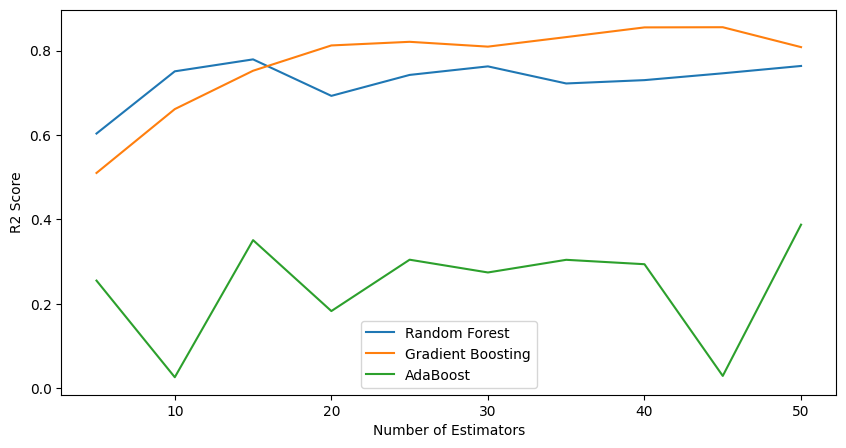

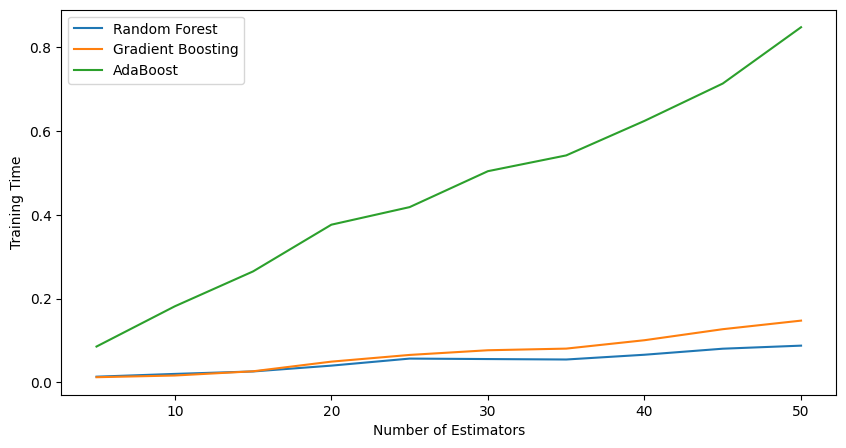

In [61]:
# Changing the number of estimators for gradient boosting regressor, random forest regressor and adaboost regressor and plotting the r2 score and training time for each model
n_estimators = [5,10,15,20,25,30,35,40,45,50]
r2_rf = []
r2_gb = []
time_rf = []
time_gb = []
r2_ada = []
time_ada = []

for n in n_estimators:
    start = time.time()
    model = RandomForestRegressor(n_estimators=n, criterion='squared_error', max_depth=10, min_samples_split=10, min_samples_leaf=1, max_features='log2', verbose=False)
    model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
    mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
    end = time.time()
    r2_rf.append(r2)
    time_rf.append(end-start)
    start = time.time()
    model = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=10, min_samples_split=10, min_samples_leaf=1, max_features='log2', verbose=False)
    model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
    mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
    end = time.time()
    r2_gb.append(r2)
    time_gb.append(end-start)
    start = time.time()
    model = Adaboost_Regressor(n_estimators=n,verbose=False)
    model.fit(X_train_Housing, y_train_Housing, X_val_Housing, y_val_Housing)
    mse,r2,rmse = model.test(X_test_Housing, y_test_Housing)
    end = time.time()
    r2_ada.append(r2)
    time_ada.append(end-start)

plt.figure(figsize=(10, 5))
plt.plot(n_estimators, r2_rf, label='Random Forest')
plt.plot(n_estimators, r2_gb, label='Gradient Boosting')
plt.plot(n_estimators, r2_ada, label='AdaBoost')
plt.xlabel("Number of Estimators")
plt.ylabel("R2 Score")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_estimators, time_rf, label='Random Forest')
plt.plot(n_estimators, time_gb, label='Gradient Boosting')
plt.plot(n_estimators, time_ada, label='AdaBoost')
plt.xlabel("Number of Estimators")
plt.ylabel("Training Time")
plt.legend()
plt.show()
